
###  10.2: Forecasting with Decomposition Models
#### Taxi Trips Forecasting

You have now learned to decompose a time series into seasonal and trend components and to use time series to forecast into the future using statsmodels. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

#### Summarize your findings in an executive brief that explores the following:
- Data description: Provide a high-level overview of your data and its timeframe along with general information on your dataset
- Forecast: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
- Uncertainty: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

##### More info in:
- Data Downloaded from: https://tlcanalytics.shinyapps.io/Data-hub/

- Main Site: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page?ref=hackernoon.com

##### Description: 
In this try-it activity, I analysed taxi trips in Manhattan (NYC). The time series I chose contains the total number of trips per month of Yellow taxis. Furthermore, the timeframe of the data is the period between 01-Jan-2010 to 01-Dec-2019. 

More info about the dataset can be found in nyc.gov. There is also a visualisation dashboard where you can analyse NYC's taxi traffic data better.

### Import Libraries
Import the necessary libraries for data manipulation, visualization, and time series analysis.

In [87]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


import statsmodels.api as sm
#from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

### Helper Functions for Visualization
Define custom functions to visualize time series decomposition results.

In [88]:
def plot_seasonal_dec(seasonal_dec_object = None, plot_size = (10, 15), title = None ):
    plt.figure(figsize=plot_size)

    plt.subplot(6, 1, 1)
    plt.title(title, fontsize = 15)
    sns.lineplot(data = seasonal_dec_object.observed, color = '#27374D')
    plt.ylabel('Observed')

    plt.subplot(6, 1, 2)
    sns.lineplot(data = seasonal_dec_object.trend, color = '#176B87')
    plt.ylabel('Trend')

    plt.subplot(6, 1, 3)
    sns.lineplot(data = seasonal_dec_object.seasonal, color = '#2E8A99')
    plt.ylabel('Seasonality')

    plt.subplot(6, 1, 4)
    sns.lineplot(data = seasonal_dec_object.resid, color = '#C70039')
    plt.ylabel('Residuals')

    plt.subplot(6, 1, 5)
    pd.plotting.autocorrelation_plot(pd.Series(seasonal_dec_object.observed), color = '#F94C10')
    plt.ylabel('Autocorrelation')
    
###################

def plot_STL(seasonal_dec_object = None, plot_size = (10, 15), title = None ):
    plt.figure(figsize=plot_size)

    plt.subplot(4, 1, 1)
    plt.title(title, fontsize = 15)
    sns.lineplot(data = seasonal_dec_object.observed, color = '#27374D')
    plt.ylabel('Observed')

    plt.subplot(4, 1, 2)
    sns.lineplot(data = seasonal_dec_object.trend, color = '#176B87')
    plt.ylabel('Trend')

    plt.subplot(4, 1, 3)
    sns.lineplot(data = seasonal_dec_object.seasonal, color = '#2E8A99')
    plt.ylabel('Seasonality')

    plt.subplot(4, 1, 4)
    sns.lineplot(data = seasonal_dec_object.resid, color = '#C70039')
    plt.ylabel('Residuals')



### Data Loading and Preprocessing
Load the NYC taxi trips dataset, filter for Yellow taxis, and prepare the data for time series analysis.

  month_date  trips_per_month
0 2010-01-01         14860656
1 2010-02-01         11143132
2 2010-03-01         12882577
3 2010-04-01         15143940
4 2010-05-01         15480594


array(['FHV - Black Car', 'FHV - High Volume', 'FHV - Livery',
       'FHV - Lux Limo', 'Green', 'Yellow'], dtype=object)

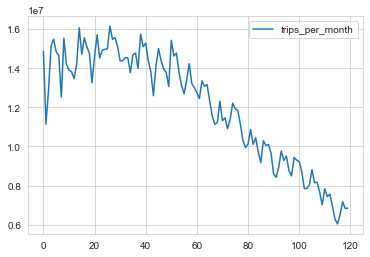

In [89]:
df = pd.read_csv("taxi_nyc_dataset/Monthly_Metrics2023-11-14.csv").query('license_class == "Yellow"')[['month_date', 'trips_per_month']] # index_col = 0, infer_datetime_format = True)
df['month_date'] = pd.to_datetime(df['month_date'], infer_datetime_format= True)
data = df.sort_values(by ='month_date', ascending = True).set_index('month_date').reset_index().iloc[:120]

value_colmn = 'trips_per_month'
time_colmn = 'month_date'
time_varname = 'month_date'

print(data.head())
sns.lineplot(data = data)



data_all = pd.read_csv("taxi_nyc_dataset/Monthly_Metrics2023-11-14.csv")
data_all['license_class'].unique()

### Data Exploration
Check the time range of our dataset.

In [90]:
print(data[time_colmn].min())
print(data[time_colmn].max())

2010-01-01 00:00:00
2019-12-01 00:00:00


### Data Visualization
Create a time series plot of the total trips per month for Yellow taxis.


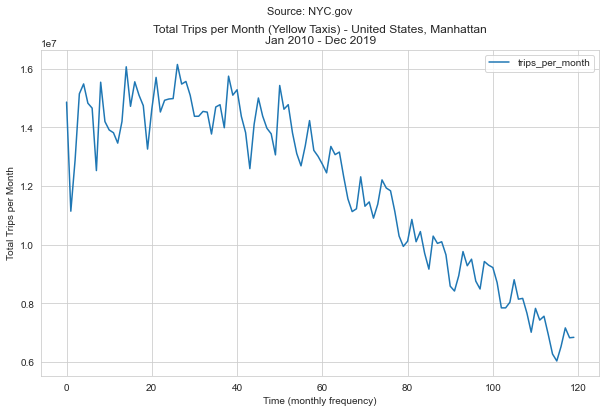

In [91]:
###################################### monthly frequency
data[[value_colmn]].plot(figsize = (10,6))
plt.suptitle('Source: NYC.gov ', fontsize = 11)
plt.title('Total Trips per Month (Yellow Taxis) - United States, Manhattan\nJan 2010 - Dec 2019')
plt.ylabel('Total Trips per Month')
plt.xlabel('Time (monthly frequency)');

### Train-Test Split
Split the data into training and testing sets based on time periods.

In [92]:
#X_train , X_test = train_test_split(data.set_index(time_colmn), test_size = 0.10, shuffle=False)

X_train = data.set_index(time_colmn).loc[:'2017-06-01']
X_test = data.set_index(time_colmn).loc['2017-07-01':'2019-01-01']

### Visualize Training Data
Plot the training data to examine its patterns.

<AxesSubplot:xlabel='month_date'>

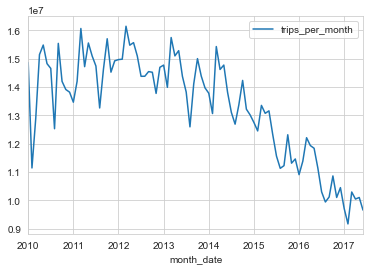

In [93]:
X_train.plot()

### Seasonal Decomposition
Decompose the time series into trend, seasonal, and residual components using an additive model.

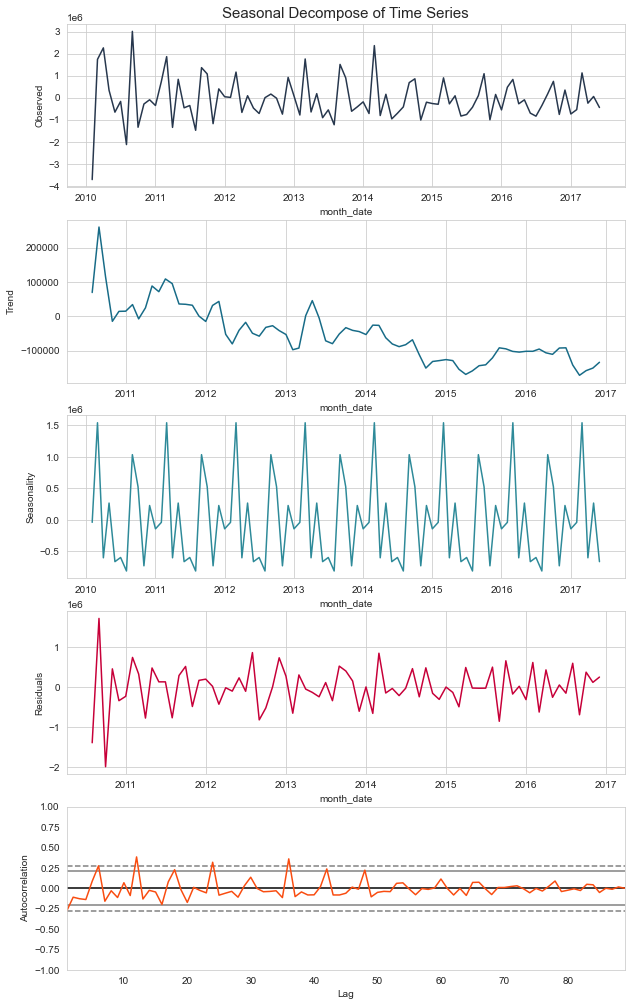

In [94]:
model1 = 'additive'
model2 = 'multiplicative'

sd_sp = seasonal_decompose(X_train[value_colmn].diff().dropna(), model = model1, period = 12)
plot_seasonal_dec(seasonal_dec_object = sd_sp, plot_size = (10, 21), title = 'Seasonal Decompose of Time Series')

 Are the residuals stationary?

In [95]:
ans = None
ans = 'Yes' if adfuller(sd_sp.resid.dropna())[1] <.05 else 'No'
print("Are the residuals stationary? -- " + ans )

Are the residuals stationary? -- Yes


## Using STL model to forecast the future

### Examine Training Data
Check the structure and last few rows of the training dataset.

In [96]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2010-01-01 to 2017-06-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   trips_per_month  90 non-null     int64
dtypes: int64(1)
memory usage: 1.4 KB


In [97]:
#X_train[time_varname] = pd.to_datetime(X_train[time_varname], infer_datetime_format= True)
#X_test[time_varname] = pd.to_datetime(X_test[time_varname], infer_datetime_format= True)
#X_train, X_test = X_train.set_index(time_varname) , X_test.set_index(time_varname)

X_train.tail()

,trips_per_month
month_date,
2017-02-01,9168628
2017-03-01,10294325
2017-04-01,10045950
2017-05-01,10101567
2017-06-01,9656310


### STL Decomposition
Apply Seasonal and Trend decomposition using LOESS (STL) to the time series data.

Are the residuals stationary? -- yes


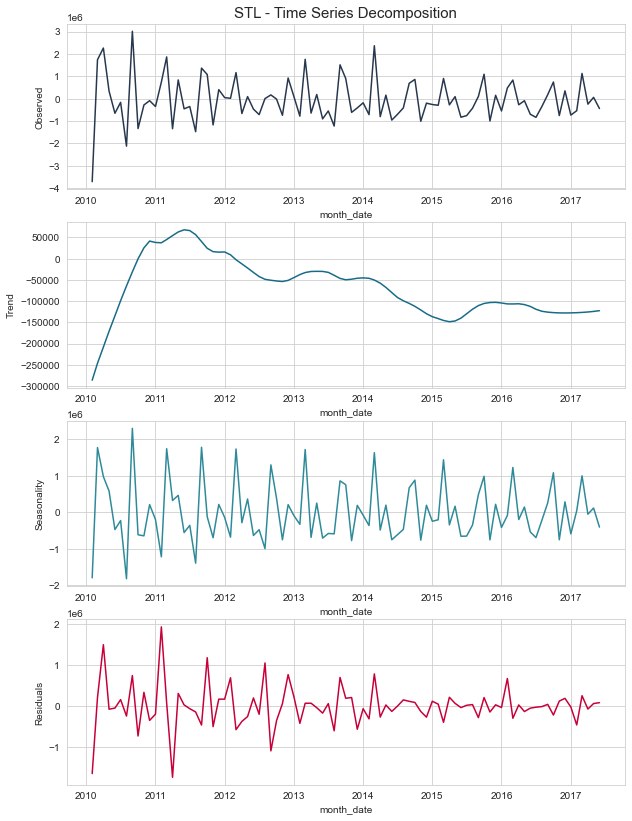

In [98]:
stl = STL(X_train[value_colmn].diff(1).dropna(), period = 12)
results = stl.fit()
ans2 = 'yes' if adfuller(results.resid)[1] < 0.05 else 'no'
print("Are the residuals stationary? -- "+ ans2 )

plot_STL(seasonal_dec_object = results, plot_size = (10, 14), title = 'STL - Time Series Decomposition')

### Seasonal and Trend Components
Combine the seasonal and trend components and compare with the actual data.

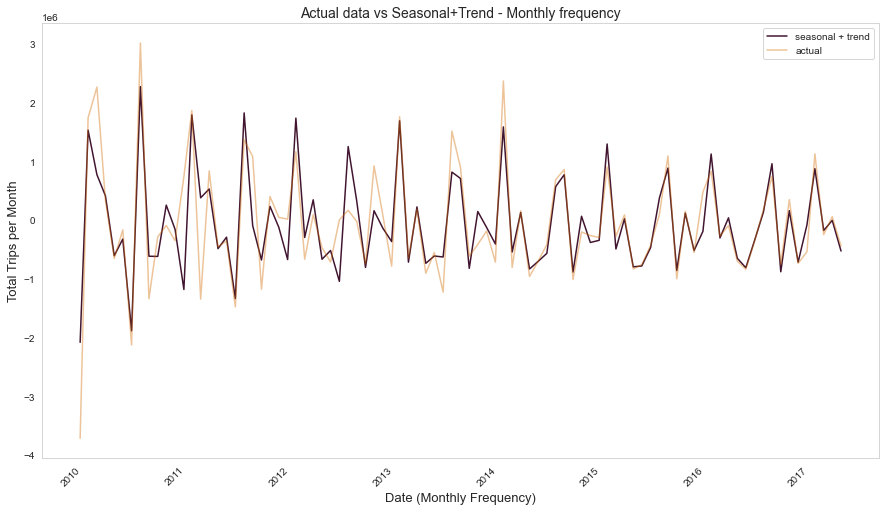

In [99]:
season_and_trend = ''
season_and_trend = results.seasonal + results.trend

plt.figure(figsize=(15,8))
plt.title('Actual data vs Seasonal+Trend - Monthly frequency', fontsize = 14)
plt.plot(season_and_trend, label = 'seasonal + trend', color = '#411530')
plt.plot(X_train[value_colmn].diff().dropna(), label = 'actual', color = '#D36B00', alpha = 0.4)
plt.xlabel('Date (Monthly Frequency)', fontsize = 13)
plt.ylabel('Total Trips per Month', fontsize = 13)
plt.legend()
plt.xticks(rotation = 45)
plt.grid();

### Autocorrelation Analysis
Examine the autocorrelation and partial autocorrelation functions to identify patterns in the data.

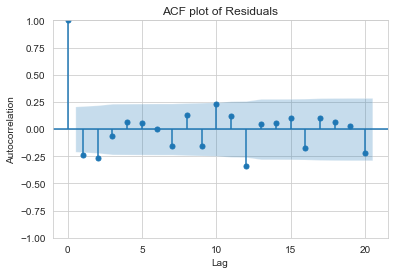

In [100]:
plot_acf(results.resid)
plt.title('ACF plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

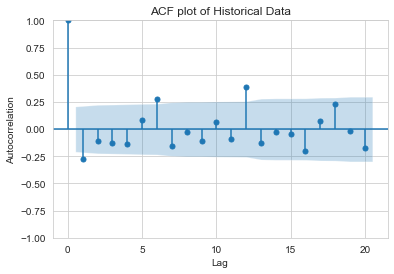

In [101]:
plot_acf(X_train[value_colmn].diff().dropna())
plt.title('ACF plot of Historical Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

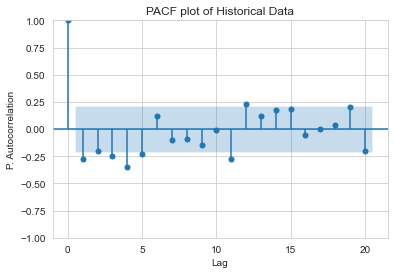

In [102]:
plot_pacf(X_train[value_colmn].diff().dropna(), method='ywm')
plt.title('PACF plot of Historical Data')
plt.xlabel('Lag')
plt.ylabel('P. Autocorrelation');


### STL Forecasting with ARIMA
Use STL decomposition with ARIMA to forecast future values.

In [103]:
#instantiate
stlf = STLForecast(X_train[value_colmn], model = ARIMA, model_kwargs={'order':(1, 1, 1), 'trend':"t"}, period = 12, ) #'order':(1, 0, 2)
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(X_test))

/Users/vassilistsoubris/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vassilistsoubris/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vassilistsoubris/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Visualize Forecast Results
Plot the forecast results against the actual data to evaluate model performance.

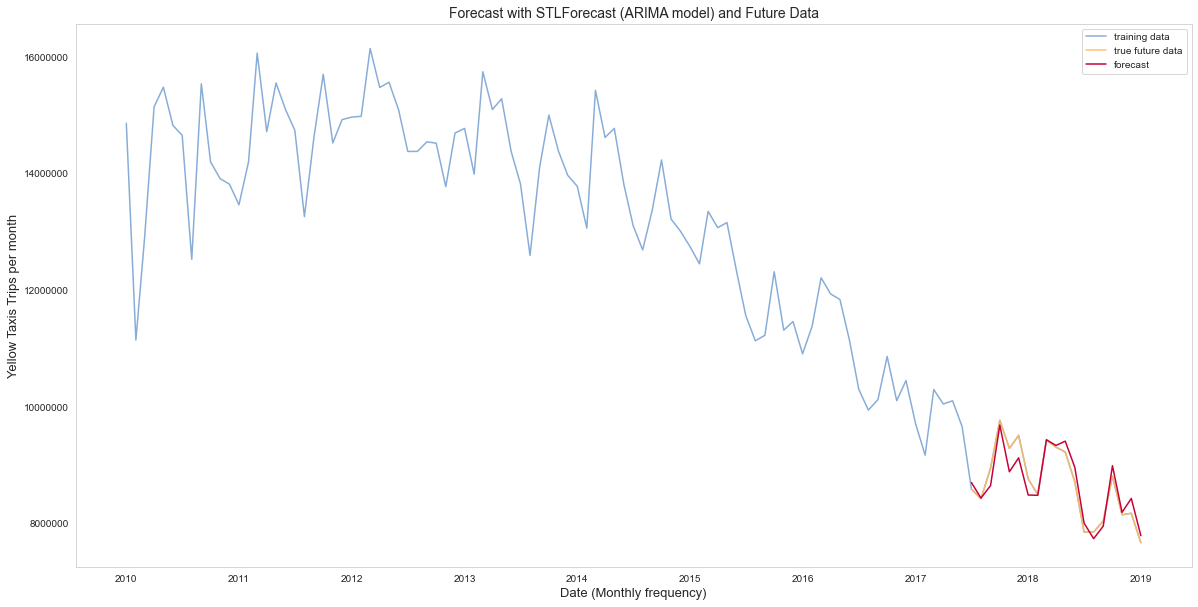

In [104]:
plt.figure(figsize=(20,10))
plt.plot(data.set_index(time_colmn).loc[:'2019-01-01'], label = 'training data', color = '#3876BF', alpha = 0.6)
plt.plot(X_test, label = 'true future data', color = '#FFBB5C', alpha = 0.9)
plt.plot(forecast, label = 'forecast', color = '#C70039')
#plt.plot(X_train, label = 'training data', color = '#3876BF', alpha = 0.6)
#plt.plot(results.trend, label = 'trend', color = '#192655' )
plt.legend()
plt.title('Forecast with STLForecast (ARIMA model) and Future Data', fontsize = 14)
plt.xlabel('Date (Monthly frequency)',fontsize = 13)
plt.ylabel('Yellow Taxis Trips per month', fontsize = 13)
plt.ticklabel_format(style='plain', axis='y')
plt.grid();

### Model Evaluation
Calculate prediction errors and evaluate model performance using Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).

In [105]:
pred_error = ''
mae = ''
rmse = ''

### BEGIN SOLUTION
pred_error = X_test[value_colmn] - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
### END SOLUTION

# Answer check
print(f'MAE: {np.round(mae,2)}')
print(f'RMSE: {np.round(rmse, 2)}')

MAE: 157823.88
RMSE: 198519.97


### Residual Analysis
Analyze the autocorrelation of prediction errors to check for any remaining patterns.

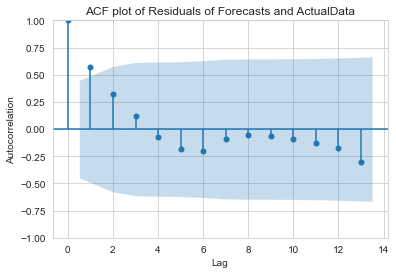

In [106]:
plot_acf(pred_error)
plt.title('ACF plot of Residuals of Forecasts and ActualData')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

### Conclusion
This analysis demonstrates the use of time series decomposition and forecasting techniques to predict taxi trip volumes in NYC. The model captures the overall trend and seasonal patterns, though there are some discrepancies in the forecast compared to actual values.